# Diabetic patients readmission rates preditction


In [96]:
pip install tqdm


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [97]:
pip install learn2learn


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [98]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset


from tqdm import tqdm

In [99]:
from learn2learn.algorithms.maml import MAML
from learn2learn.data import TaskDataset

# Project introduction

- Overview: <br>
This project is focusing on developing a predictive model to ascertain the likelihood of readmission for diabetes patients.
<br>

- Target:<br>
The main goal of this project is developing a powerful machine learning model which can predict the readmission rate of patient 

# Data loading
The following cells are used to load training and testing data for our prediction

In [100]:
train_data = pd.read_csv("Dataset/diabetic_data_training.csv")
test_data = pd.read_csv("Dataset/diabetic_data_test.csv")
mapping_info = pd.read_csv("Dataset/IDS_mapping.csv", header=None)

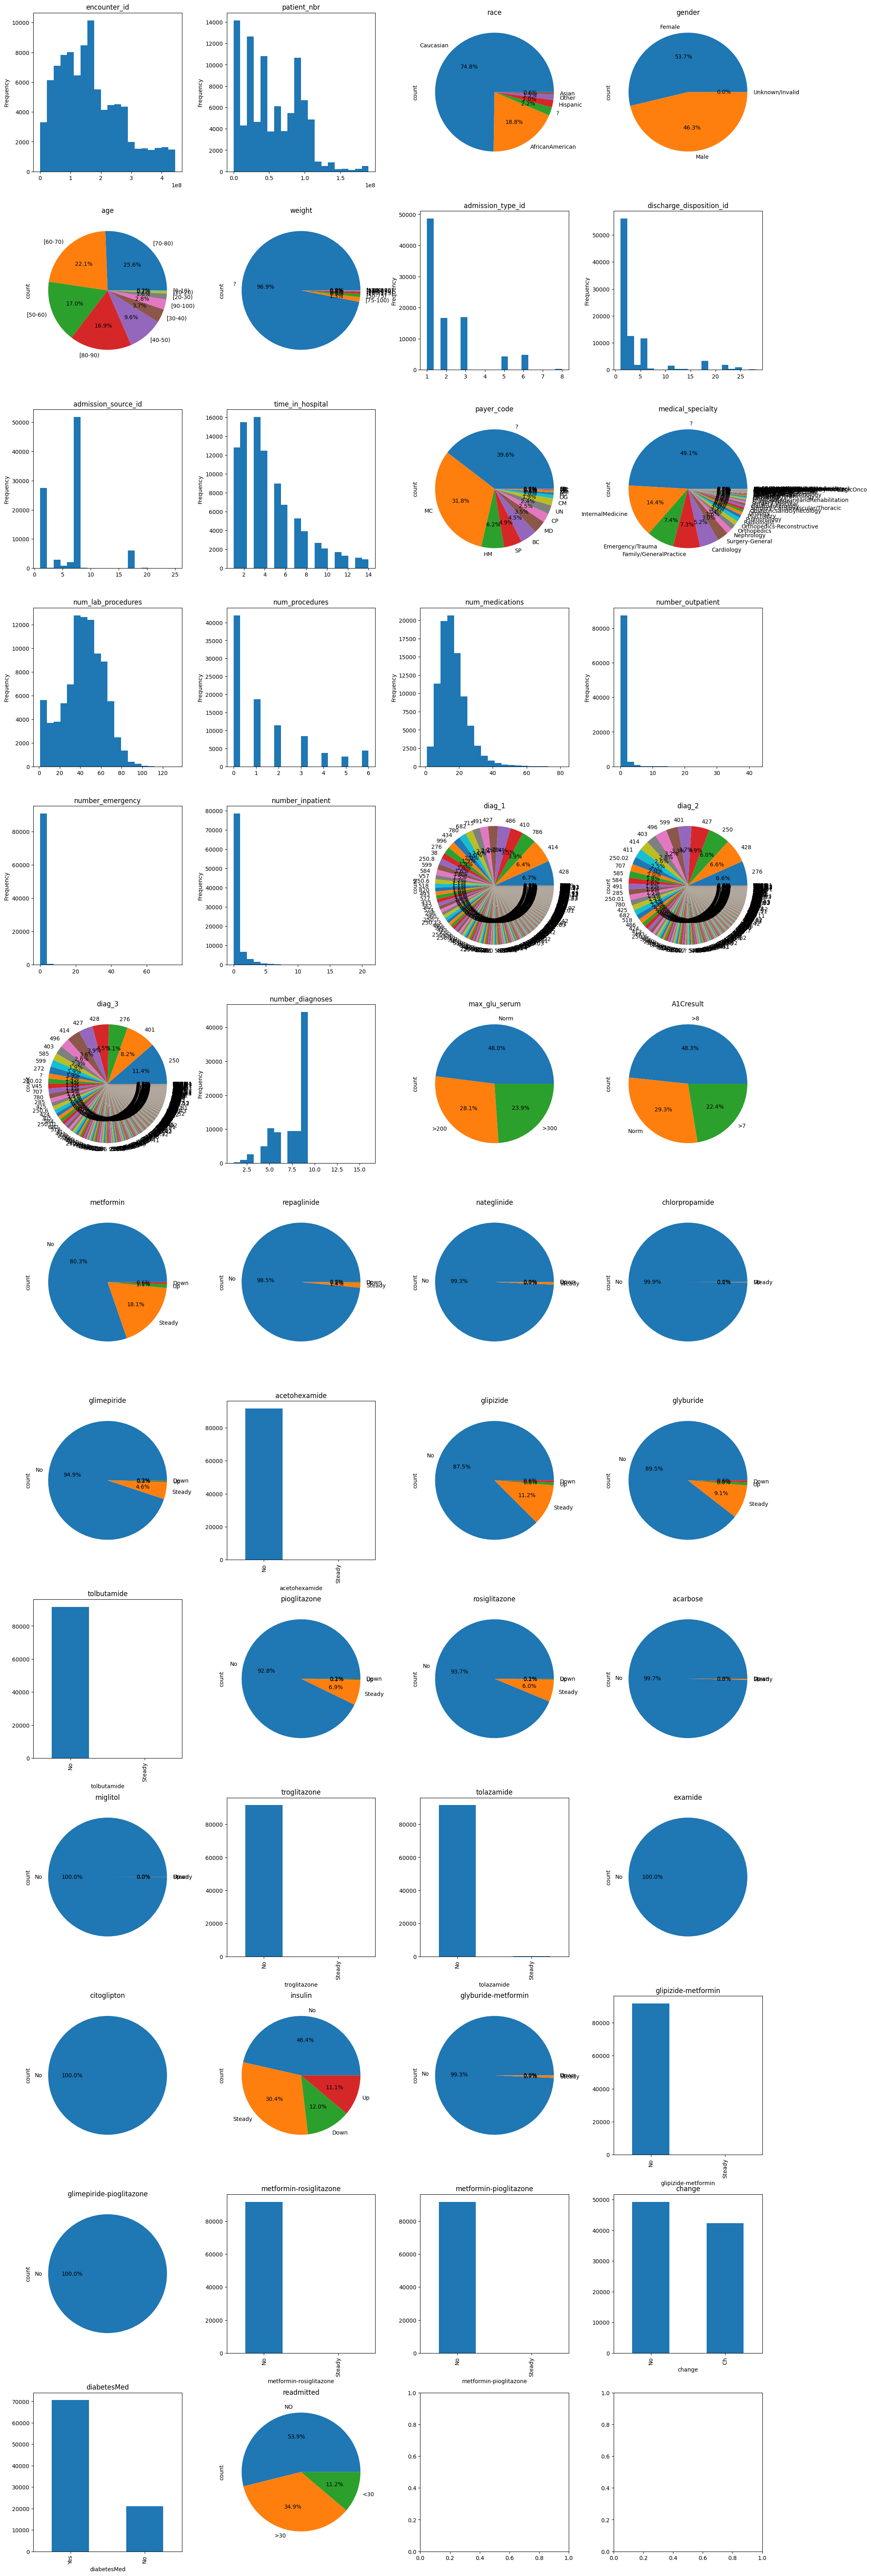

In [101]:
# Function to handle different data types for plotting
def plot_column(ax, column, df):
    if df[column].dtype == 'object':
        # Check if binary
        if df[column].nunique() == 2:
            # Binary data visualization
            df[column].value_counts().plot(kind='bar', ax=ax)
        else:
            # Categorical data visualization
            df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
    elif df[column].dtype == 'int64' or df[column].dtype == 'float64':
        # Numeric data visualization
        df[column].plot(kind='hist', bins=20, ax=ax)
    else:
        ax.text(0.5, 0.5, f"Unhandled data type for column: {column}", 
                fontsize=12, ha='center')
    ax.set_title(column)

# Creating a 4x4 subplot layout
fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(20, 65))
fig.tight_layout(pad=5.0)

# Iterate through each column and plot
for i, col in enumerate(train_data.columns):
    # Adjust this line to select different subsets of columns  
    plot_column(axes[i//4, i%4], col,train_data)


plt.show()


# Data preprocessing
The following cells are used to preprocess the training and testing data. There are two main goals in our preprocessing data section of the code
- Change the string type data in our dataset to integer type data 
- Apply some applicable method to full up the missing value

In [102]:
# # this part just make a dictionary to mapping the id between data and ID mapping table
# mapping_dicts = [{} for i in range(3)]
# mapping_title = []
# title = -1
# for data in mapping_info.itertuples():
#     if(pd.isna(data[1])):
#         continue
#     if(not data[1].isdigit()):
#         title += 1
#         mapping_title.append(data[1])
#     else:
#         if(pd.isna(data[2])):
#             mapping_dicts[title]['NULL'] = data[1]
#             continue
#         mapping_dicts[title][data[2]] = data[1]

In [105]:
# this part is used to change all string type data to integer type
# for the missing value, we will skip and process it at next step
df = train_data.copy()


df_test = test_data.copy()


In [ ]:

# mask = df.isna().sum(axis=1) <= 3
# filtered_df = df[mask]
# print(filtered_df.any(axis=1).sum())

78333


One-Hot Encoding For race:
cons: One-hot encoding can lead to a significant increase in the dataset's dimensionality (a problem known as the "curse of dimensionality"), especially if the categorical feature has many unique values. This can increase the computational cost and may require more data to achieve good performance.
Dems Redct Would be apply, so it doesn't matter
pros: Map to a fix number implies an ordinal relationship between the categories which may not exist, but is ideal for non-ordinal categorical data. It's suitable for many machine learning models, especially those that assume no ordinal relationship between categories


1. random forest, remove ?
2. randomly assign ? to a class by disstribution

General Missing value
1. multiple imputation To be decide when training if less than 1h 5 epoch
2. mean
3. fullly remove
4. wrong -> fix ?


Encoding for age:
1. Asumming normal distribution, map to a random age in the range
2. Map to mean age in the range

Race Process
1. Remove missing since race is proved to be a significant impact to medical result.
2. One-hot encode race

In [107]:
def race_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    race_mask = (df['race'] != "?")
    df = df[race_mask]
    return df

In [111]:
df = race_filter(df)
df_encoded = pd.get_dummies(df, columns=["race"], prefix="race")

df_test = race_filter(df_test)
df_test_encoded = pd.get_dummies(df_test, columns=["race"], prefix="race")

Gender Process
1. Remove Unknown/Invalid and missing
2. One hot encode Gender

In [ ]:
def gender_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    gender_mask = (df['gender'] != "Unknown/Invalid")
    df = df[gender_mask]
    return df

In [ ]:
df_encoded = gender_filter(df_encoded)
df_test_encoded = gender_filter(df_test_encoded)

Age Process
1. n/a
2. Map age from range to mean

In [ ]:
df_encoded['age'] = (df['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2
df_test_encoded['age'] = (df_test['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df_test['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2

Weight Process
1. Drop Weight for too many missing values and no information to predict.
2. n/a

In [ ]:
df_encoded.drop(columns=['weight'], inplace=True)
df_test_encoded.drop(columns=['weight'], inplace=True)

admission_type_id
discharge_disposition_id
admission_source_id
To be merged

Payer Code and Medical Specialty Process
1. Both droped since too many missing
2. Payer Code not relevant as id, Medical Specialty too many categories and no info to predict.

In [ ]:
df_encoded.drop(columns=['payer_code'], inplace=True)
df_encoded.drop(columns=['medical_specialty'], inplace=True)
df_test_encoded.drop(columns=['payer_code'], inplace=True)
df_test_encoded.drop(columns=['medical_specialty'], inplace=True)

In [ ]:
# df_pc = df['payer_code'].astype('category')
# unique_categories_pc = df_pc.cat.categories
# medical_specialty_to_num = {medical_specialty: i for i, medical_specialty in enumerate(unique_categories_pc)}
# max_binary_length = len(bin(len(unique_categories_pc) - 1)) - 2
# payer_code_to_binary = {medical_specialty: bin(num)[2:].zfill(max_binary_length) for medical_specialty, num in medical_specialty_to_num.items()}

# df_encoded['payer_code'] = df_encoded['payer_code'].map(payer_code_to_binary)

# df_test_encoded['payer_code'] = df_test_encoded['payer_code'].map(payer_code_to_binary)
# df_ms = df['medical_specialty'].astype('category')
# unique_categories_ms = df_ms.cat.categories
# medical_specialty_to_num = {medical_specialty: i for i, medical_specialty in enumerate(unique_categories_ms)}
# max_binary_length = len(bin(len(unique_categories_ms) - 1)) - 2
# medical_specialty_to_binary = {medical_specialty: bin(num)[2:].zfill(max_binary_length) for medical_specialty, num in medical_specialty_to_num.items()}

# df_encoded['medical_specialty'] = df_encoded['medical_specialty'].map(medical_specialty_to_binary)

# df_test_encoded['medical_specialty'] = df_test_encoded['medical_specialty'].map(medical_specialty_to_binary)

num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
No need to be encode since no missing and integer.

diag_1,diag_2 and diag_3 Process:
1. Filte diag_1, diag_2 and diag_3 by number_diagnoses. If the amount of diagnoses in diag_1, diag_2 and diag_3 doesn't match the number_diagnoses, then remove.
2. Layer encoding diags according to the ICD-9 Code Category

In [91]:
def diag_missing_value_filter(df):

    df['number_diagnoses'] = pd.to_numeric(df['number_diagnoses'], errors='coerce')
    mask = ((df['number_diagnoses'] <= 3) & (
            (3 - df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) >= df['number_diagnoses'])) | (
    (df['number_diagnoses'] > 3) & (df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) == 0) 
    df_filtered = df[mask].copy()

    return df_filtered

def diag_layer_encoding(element):
    if isinstance(element, (int,float)):
        # Encode based on numeric range
        if 1 <= element <= 139:
            return [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 140 <= element <= 239:
            return [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 240 <= element <= 279:
            return [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 280 <= element <= 289:
            return [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 290 <= element <= 319:
            return [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 320 <= element <= 389:
            return [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 390 <= element <= 459:
            return [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 460 <= element <= 519:
            return [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 520 <= element <= 579:
            return [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 580 <= element <= 629:
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 630 <= element <= 679:
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        elif 680 <= element <= 709:
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        elif 710 <= element <= 739:
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
        elif 740 <= element <= 759:
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
        elif 760 <= element <= 779:
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
        elif 780 <= element <= 799:
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
        elif 800 <= element <= 999:
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
        # Add more conditions for other ranges if needed

    elif isinstance(element, str):
        # Encode based on string prefix
        if element.startswith('E'):
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
        elif element.startswith('V'):
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
        elif element.startswith('M'):
            return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        # Add more conditions for other prefixes if needed

    # Default case (not a number or string with known prefix)
    return [0] * 20

In [ ]:
def diag_layer_encoding(df):

    # Define the encoding function
    def encode_element(element):
        encoding_result = [0] * 20  # Default encoding
        if isinstance(element, (int, float)):
            # Encode based on numeric range
                if 1 <= element <= 139:
                    encoding_result[0] = 1
                elif 140 <= element <= 239:
                    encoding_result[1] = 1
                elif 240 <= element <= 279:
                    encoding_result[2] = 1
                elif 280 <= element <= 289:
                    encoding_result[3] = 1
                elif 290 <= element <= 319:
                    encoding_result[4] = 1
                elif 320 <= element <= 389:
                    encoding_result[5] = 1
                elif 390 <= element <= 459:
                    encoding_result[6] = 1
                elif 460 <= element <= 519:
                    encoding_result[7] = 1
                elif 520 <= element <= 579:
                    encoding_result[8] = 1
                elif 580 <= element <= 629:
                    encoding_result[9] = 1
                elif 630 <= element <= 679:
                    encoding_result[10] = 1
                elif 680 <= element <= 709:
                    encoding_result[11] = 1
                elif 710 <= element <= 739:
                    encoding_result[12] = 1
                elif 740 <= element <= 759:
                    encoding_result[13] = 1
                elif 760 <= element <= 779:
                    encoding_result[14] = 1
                elif 780 <= element <= 799:
                    encoding_result[15] = 1
                elif 800 <= element <= 999:
                    encoding_result[16] = 1
                # Add more conditions for other ranges if needed
        elif isinstance(element, str):
                # Encode based on string prefix
            if element.startswith('E'):
                encoding_result[17] = 1
            elif element.startswith('V'):
                encoding_result[18] = 1
            elif element.startswith('M'):
                encoding_result[19] = 1
        return encoding_result

    # Apply the encoding function to the specified column
    encoded_columns = df["diag_1"].apply(encode_element)

    # Create new columns with "diag_1" as a prefix
    for i in range(20):
        new_column_name = f"diag_1_{i+1}"
        df[new_column_name] = encoded_columns.apply(lambda x: x[i])

    return df

# Example usage:
# Assuming 'df' is your DataFrame and 'diag_column' is the column to be encoded
df = diag_layer_encoding(df, 'diag_column')
print(df)

In [ ]:
Name = ['race','gender','change','diabetesMed']
df_encoded = pd.get_dummies(df, columns=Name, prefix=Name)
df_test_encoded = pd.get_dummies(df_test, columns=Name, prefix=Name)

In [23]:
medicion_mapping = {'No':0,'Down':1,'Steady':2,'Up':3}
max_glu_serum_mapping = {'>200': 201, '>300': 301, 'normal': 0,}
A1Cresult_mapping = {'>8':9,'>7':7.5,'normal':6}
readmitted_mapping = {'NO':0,'<30':1,'>30':2}

In [24]:
df_encoded['max_glu_serum'] = df_encoded['max_glu_serum'].map(max_glu_serum_mapping)

df_test_encoded['max_glu_serum'] = df_test_encoded['max_glu_serum'].map(max_glu_serum_mapping)

In [25]:
df_encoded["A1Cresult"] = df_encoded['A1Cresult'].map(A1Cresult_mapping)

df_test_encoded["A1Cresult"] = df_test_encoded['A1Cresult'].map(A1Cresult_mapping)

In [26]:
df_encoded['readmitted'] = df_encoded['readmitted'].map(readmitted_mapping)

df_test_encoded['readmitted'] = df_test_encoded['readmitted'].map(readmitted_mapping)

In [27]:
for index,name in enumerate(df.columns):
    if(index >= 23 and index <= 45):
        df_encoded[name] = df_encoded[name].map(medicion_mapping)

for index,name in enumerate(df_test.columns):
    if(index >= 23 and index <= 45):
        df_test_encoded[name] = df_test_encoded[name].map(medicion_mapping)

In [28]:
df_encoded.drop(columns=['diag_1'], inplace=True)
df_encoded.drop(columns=['diag_2'], inplace=True)
df_encoded.drop(columns=['diag_3'], inplace=True)
df_encoded.drop(columns=['number_diagnoses'], inplace=True)

df_test_encoded.drop(columns=['diag_1'], inplace=True)
df_test_encoded.drop(columns=['diag_2'], inplace=True)
df_test_encoded.drop(columns=['diag_3'], inplace=True)
df_test_encoded.drop(columns=['number_diagnoses'], inplace=True)

encode payer_code, medical_specialty
1. Find correlation internally with other feature in group of non-missing value
2. Use identified feature predict payer-code, medical_specialty
3. Prediction algorithm to be decide, could be KNN

encode diag_1,diag_2,diag_3
1. one hot
3. remove missing
3. One hot to a 18 dim feature according to the categral of ICD code
4. map each categral to a real number with small relative difference

encoding all medicine:
map to 0-3

In [29]:
# this part will recognise the ?, the missing value in training data
# When we have recognised it, we will use **** method to full up it
# the method we can discuss: 
#   delete
#   mean,median or mode
#   knn to predict
#   Multiple Imputation

In [30]:
# this part will reduce the dimension our training data

Dems Redct
1. PCA/PPCA
2. LDA/QDA
3. following to T-SNE
3. Autoencoders
4. Unsupervised Algorithmn

In [31]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Simulating Data
np.random.seed(0)
num_samples = 1000
num_features = 5

# Numerical data
numeric_data = np.random.randn(num_samples, num_features)

# Categorical data (let's say, colors)
colors = ['Red', 'Green', 'Blue']
categorical_data = np.random.choice(colors, size=num_samples)

# Convert categorical data to one-hot encoding
encoder = OneHotEncoder(sparse=False)
categorical_encoded = encoder.fit_transform(categorical_data.reshape(-1, 1))

# Combining numerical and categorical data
combined_data = np.hstack((numeric_data, categorical_encoded))

# Standardize the numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
pca_result = pca.fit_transform(scaled_data)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

# Plotting the results
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=categorical_data, palette='bright')
plt.title('t-SNE plot of the dataset')
plt.xlabel('t-SNE Axis 1')


/home/codespace/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


NameError: name 'sns' is not defined

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_shape = combined_data.shape[1]  # combined data from previous steps
encoding_dim = 32  # example of encoding dimension

# This is our input placeholder
input_data = Input(shape=(input_shape,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_data)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_shape, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(combined_data, combined_data, epochs=50, batch_size=256, shuffle=True)


# Model Building
We will build two models: 
1. A traditional machine learning model using Random Forest.
2. A deep learning model using PyTorch.


At the first step we will try to use the Random Forest method to get the result

In [ ]:
# the code for Random Forest algorithm

In [ ]:
# the code for Nerual Network

# Model Training


In [ ]:
# training loop
# Random Forest
X = df_encoded.drop('readmitted', axis=1)
Y = df_encoded['readmitted']
rf_classifier = HistGradientBoostingClassifier(max_iter=100, random_state=42)
rf_classifier.fit(X, Y)

# Nerual Network

# Model Evaluation

In [ ]:
# use testing dataset to predict
X_test = df_test_encoded.drop('readmitted', axis=1)
Y_test = df_test_encoded['readmitted']

Y_pred = rf_classifier.predict(X_test)
print(Y_pred)
print(Y_test)
print(accuracy_score(Y_test,Y_pred))